# Outline of notebook

The runs vary in: 
* Latent space size: 32 & 64
* Objective: $\beta$-VAE or autoencoder
* Free-bits: 0.0 (normal VAE), 0.25, 0.5, 0.75, 1.0, 1.5

# Imports

In [1]:
import sys; sys.path.append("../")
from dataset_wrappper import NewsData
from utils_train import transfer_batch_to_device
import os
from run_validation import load_model_for_eval
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast
import torch
from utils_evaluation import tokenizer_batch_decode
import numpy as np
import copy
import pickle
import pandas as pd

plt.style.reload_library()
plt.style.use('thesis_style')

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Globals

In [2]:
BATCH_SIZE = 64
DEVICE = "cuda:0"
CHECKPOINT_TYPE = "best" # else "best"
RESULT_DIR = Path("result-files")

# Data, data loader and tokenizer

In [3]:
data = NewsData(batch_size=BATCH_SIZE, tokenizer_name="roberta", dataset_name="ptb_text_only", max_seq_len=64)
validation_loader = data.val_dataloader(batch_size=BATCH_SIZE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Is file!
train 42068
validation 3370
test 3761


# Fetch the model paths we want to evaluate

In [4]:
def get_clean_name(run_name):
    latent_size = run_name.split("-")[4][-2:]
    if "autoencoder" in run_name:
        FB = "autoencoder"
    else:
        FB = run_name.split("-")[6]
        if len(FB) == 3:
            FB += "0"
        FB = "FB-" + FB
    clean_name = f"NZ-{latent_size} | {FB}"
    return clean_name

In [5]:
PTB_run_name_paths = {}
for r in os.listdir("../Runs"):
    if "PTB" in r:
        path = Path("../Runs") / r / f"checkpoint-{CHECKPOINT_TYPE}.pth"
        PTB_run_name_paths[r] = path

clean_names = []
for r in PTB_run_name_paths.keys():
#     print(get_clean_name(r))
    clean_names.append(get_clean_name(r))
    
clean_names = sorted(clean_names)

# 1 Visualise the latents of the validation set by different runs

In [6]:
results_latents = {}

for AUTO_REGRESSIVE in [False, True]:
    MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'
    RESULT_FILE = RESULT_DIR / f"result_latents_{MODE}_23feb.pickle"

    if os.path.exists(RESULT_FILE):
        print(f"Loading file {RESULT_FILE}, it existed.")
        res_dict = pickle.load( open( RESULT_FILE, "rb" ) )
    else:
        res_dict = {}
    
    for i, (r, p) in enumerate(PTB_run_name_paths.items()):
        print(i, r)
        
        if r in res_dict:
            print("Skipping this run, already in result dict!")
            continue

        latent_size = int(r.split("-")[4][-2:])
        vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                        latent_size=latent_size, 
                                        add_latent_via_memory=True,
                                        add_latent_via_embeddings=False, 
                                        do_tie_weights=True, 
                                        do_tie_embedding_spaces=True,
                                        add_decoder_output_embedding_bias=False)


        N = len(validation_loader)
        latents, mus, logvars = [], [], []
        with torch.no_grad():
            for batch_i, batch in enumerate(validation_loader):
                print(f"{batch_i:3d}/{N}", end="\r")
                batch = transfer_batch_to_device(batch, DEVICE)
                
                n_samples = 1
                enc_out = vae_model.encoder.encode(batch["input_ids"], batch["attention_mask"], n_samples=n_samples,
                                                      hinge_kl_loss_lambda=0.0,
                                                      return_log_q_z_x=True,
                                                      return_log_p_z=True,
                                                      return_embeddings=False)
                
                latents.append(enc_out["latent_z"])
                mus.append(enc_out["mu"])
                logvars.append(enc_out["logvar"])
                
            latents = torch.cat(latents, dim=0)
            mus = torch.cat(mus, dim=0)
            logvars = torch.cat(logvars, dim=0)
            
            res_dict[r] = {
                "latents": latents.cpu(),
                "mus": mus.cpu(),
                "logvars": logvars.cpu()
            }
            
            # Dump results after every model so we don't need to start over in case of a crash
            pickle.dump( res_dict, open( RESULT_FILE, "wb" ) )
        
    results_latents[MODE] = res_dict
    
    break
#         res_dict[r] ={
#             ...
#         }

#         pickle.dump( res_dict, open( RESULT_FILE_PPL, "wb" ) )
    
#     results_rate_distortion[MODE] = res_dict

Loading file result-files/result_latents_TF_23feb.pickle, it existed.
0 2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Skipping this run, already in result dict!
1 2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Skipping this run, already in result dict!
2 2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Skipping this run, already in result dict!
3 2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Skipping this run, already in result dict!
4 2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Skipping this run, already in result dict!
5 2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Skipping this run, already in result dict!
6 2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Skipping this run, already in result dict!
7 2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Skipping this run, already in result dict!
8 2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
Skipping this run, already in result dict!
9 2021-02-03-PTB-latent64-autoencoder-run-18:25:57
Skipping this run, already in result dict!
10 2021-02-02-PTB-latent3

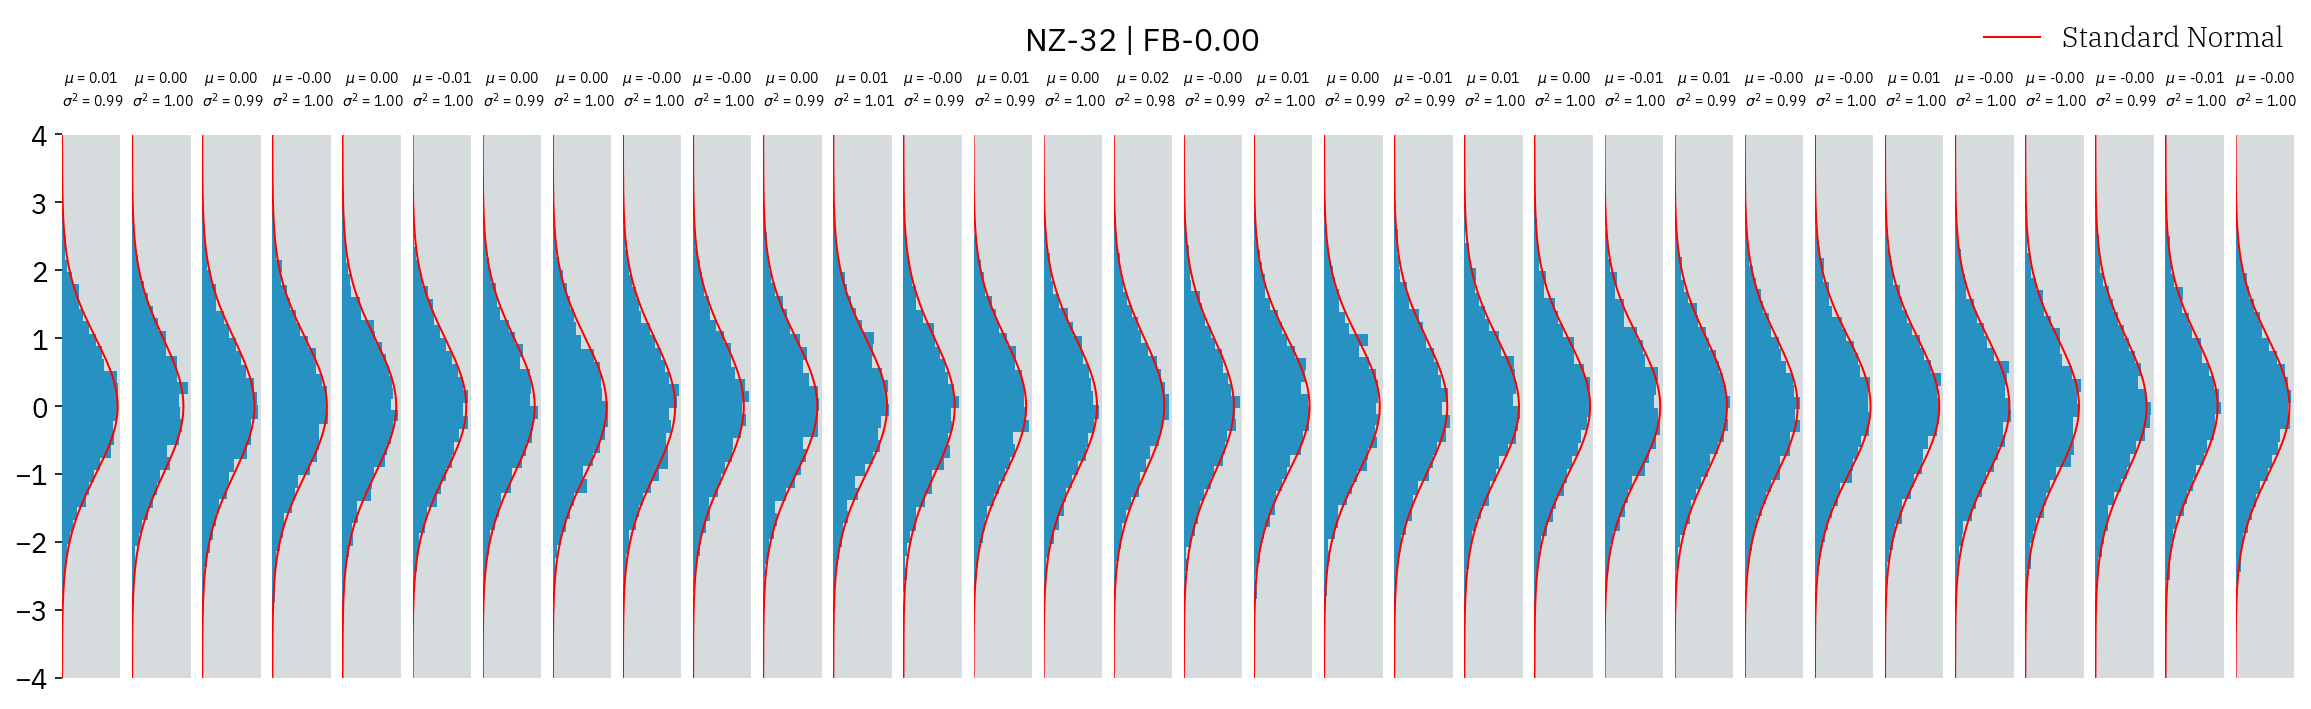

In [7]:
MODE = "TF"

import scipy.stats

x = np.linspace(-4, 4, 500)
y = scipy.stats.norm.pdf(x, 0, 1)

runs = \
["2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
 "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02", 
 "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17", 
 "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
 "2021-02-03-PTB-latent32-autoencoder-run-17:30:41"]

# for row, (r, r_dict) in enumerate(results_latents[MODE].items()):

for r in runs:
    r_dict = results_latents[MODE][r]
    latents = r_dict["latents"][:, :].numpy()
    
    mean_mean = r_dict["mus"].mean(dim=0)
    var_mean = r_dict["logvars"].exp().mean(dim=0)
    
#     print(latents.shape)
#     print(get_clean_name(r))
    
    latent_size = int(r.split("-")[4][-2:])
    
    fig, axs = plt.subplots(nrows=1, ncols=latent_size, figsize=(20, 5))

    for i in range(latent_size):
        # print("dim", i)
        axs[i].grid(b=False, which="both")
        if i > 0:
            axs[i].set_yticks([])
        axs[i].grid = False
        axs[i].set_xticks([])
        axs[i].hist(latents[:, i], orientation="horizontal", bins=40, density=True)
        axs[i].set_ylim([-4, 4])
        #axs[i].axhline(color='b', linewidth=1) #xmin=0, xmax=50, 
        axs[i].plot(y, x, color='r', linewidth=1, label="Standard Normal")
        axs[i].set_title(f"$\mu$ = {mean_mean[i]:.2f}\n $\sigma^2$ = {var_mean[i]:.2f}", size=7, y=1.03)
               
    axs[-1].legend(loc=(-4.5, 1.13), prop={'family':'serif','weight':300, 'size':14})

    fig.suptitle(get_clean_name(r), size=16, y=1.03)
    plt.show()
    
    break

NZ-32 | FB-0.00


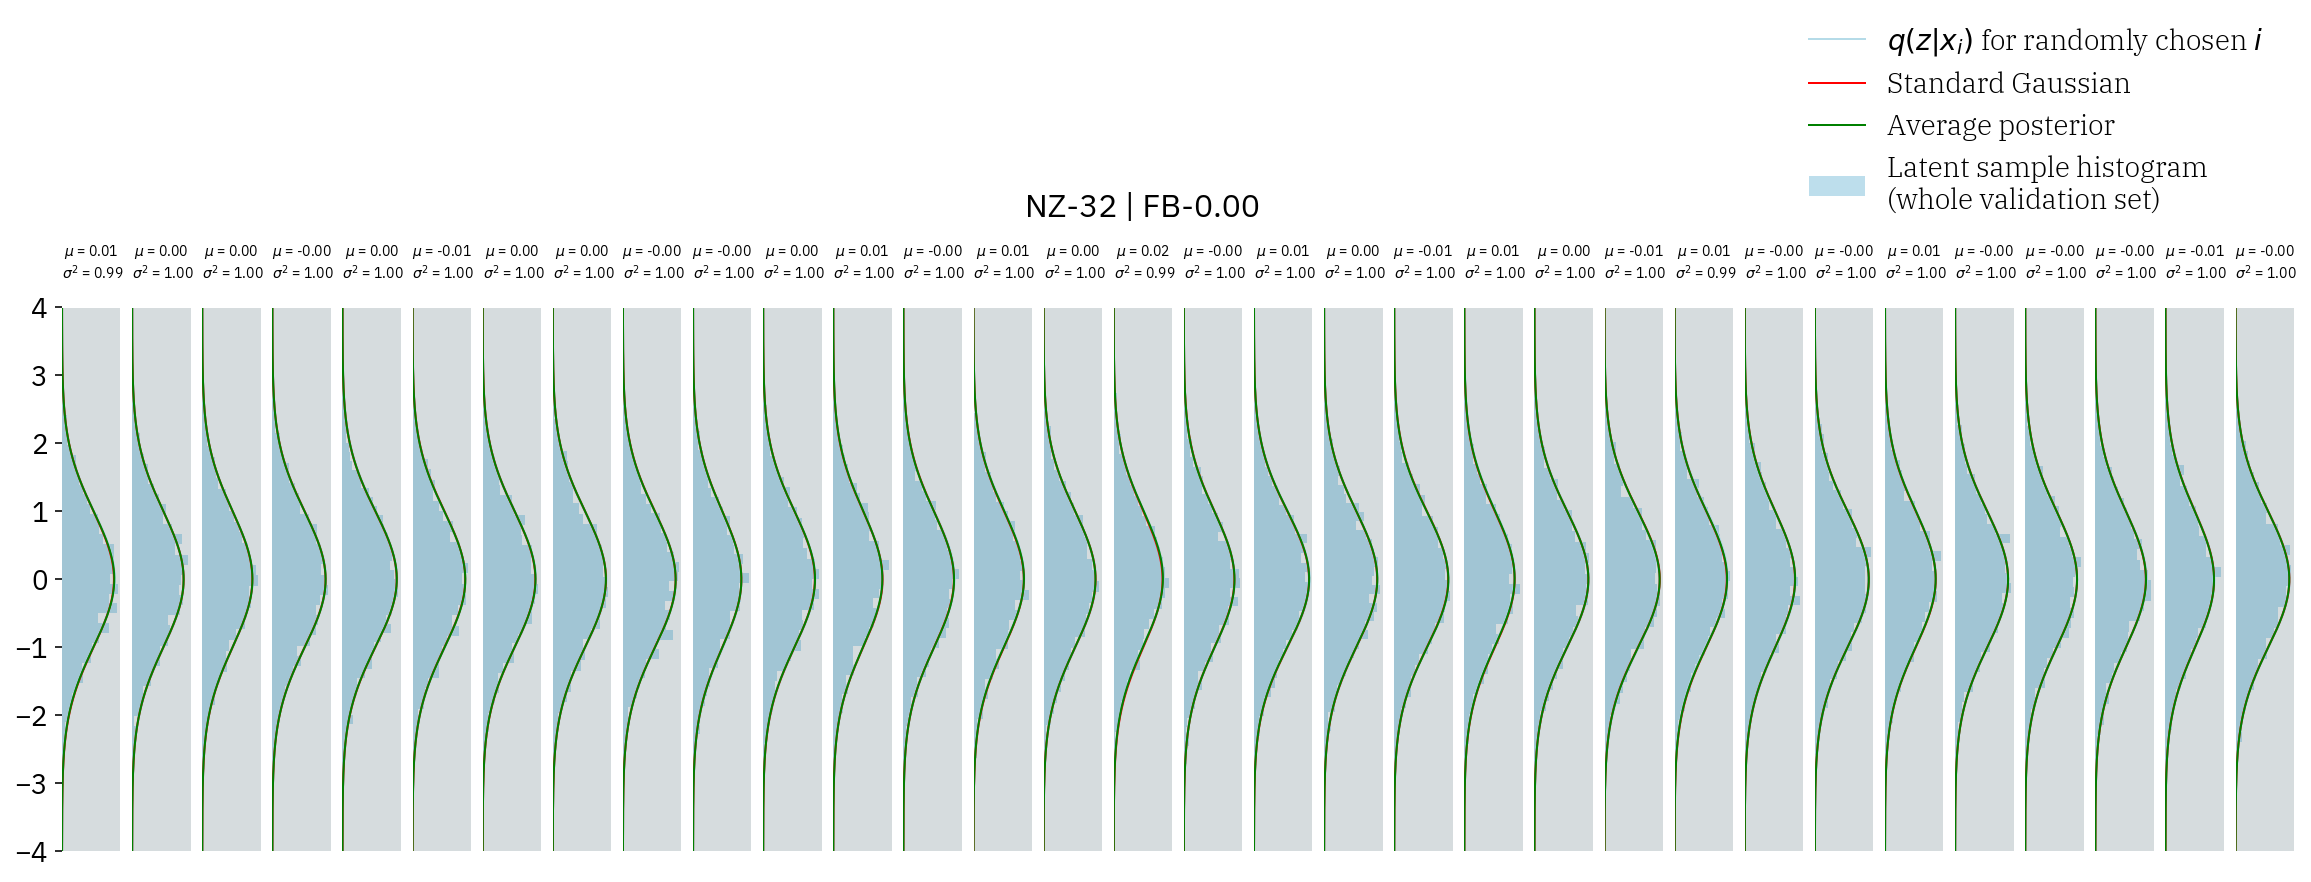

NZ-32 | FB-0.50


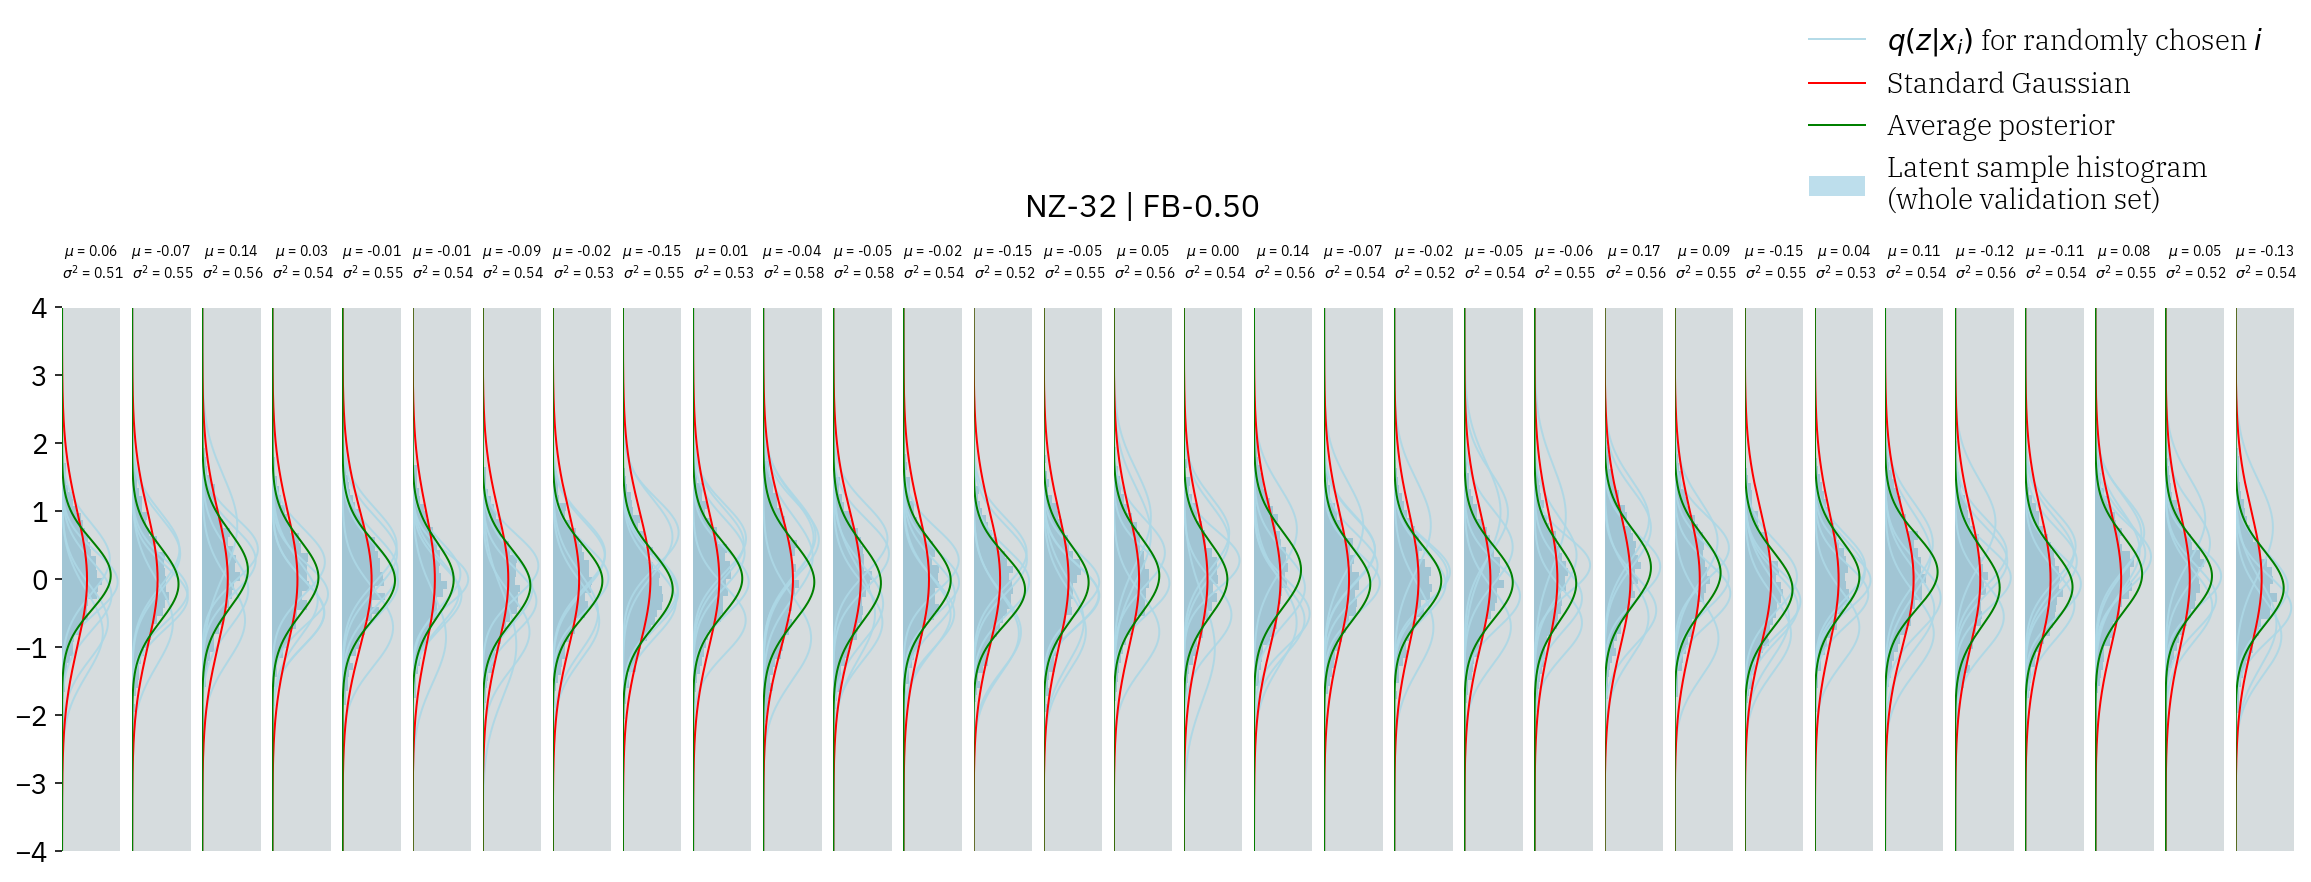

NZ-32 | FB-1.00


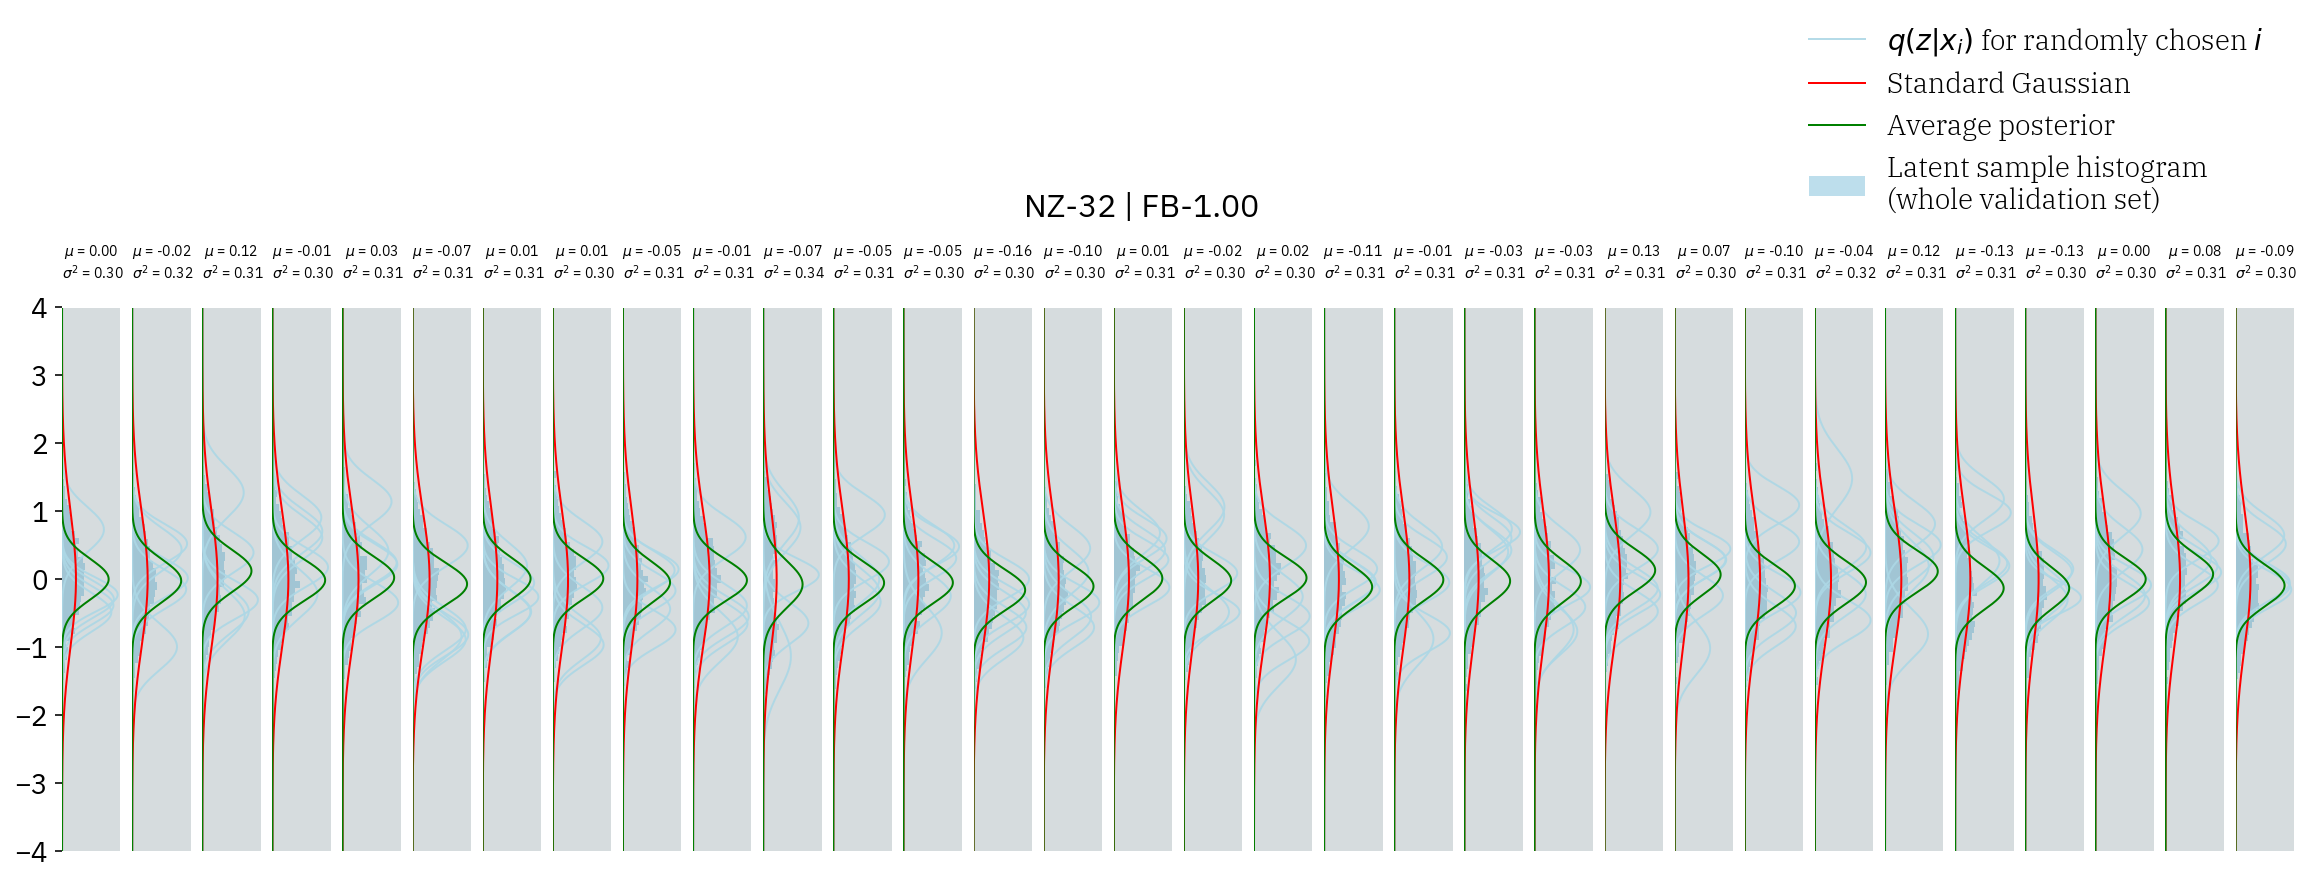

NZ-32 | FB-1.50


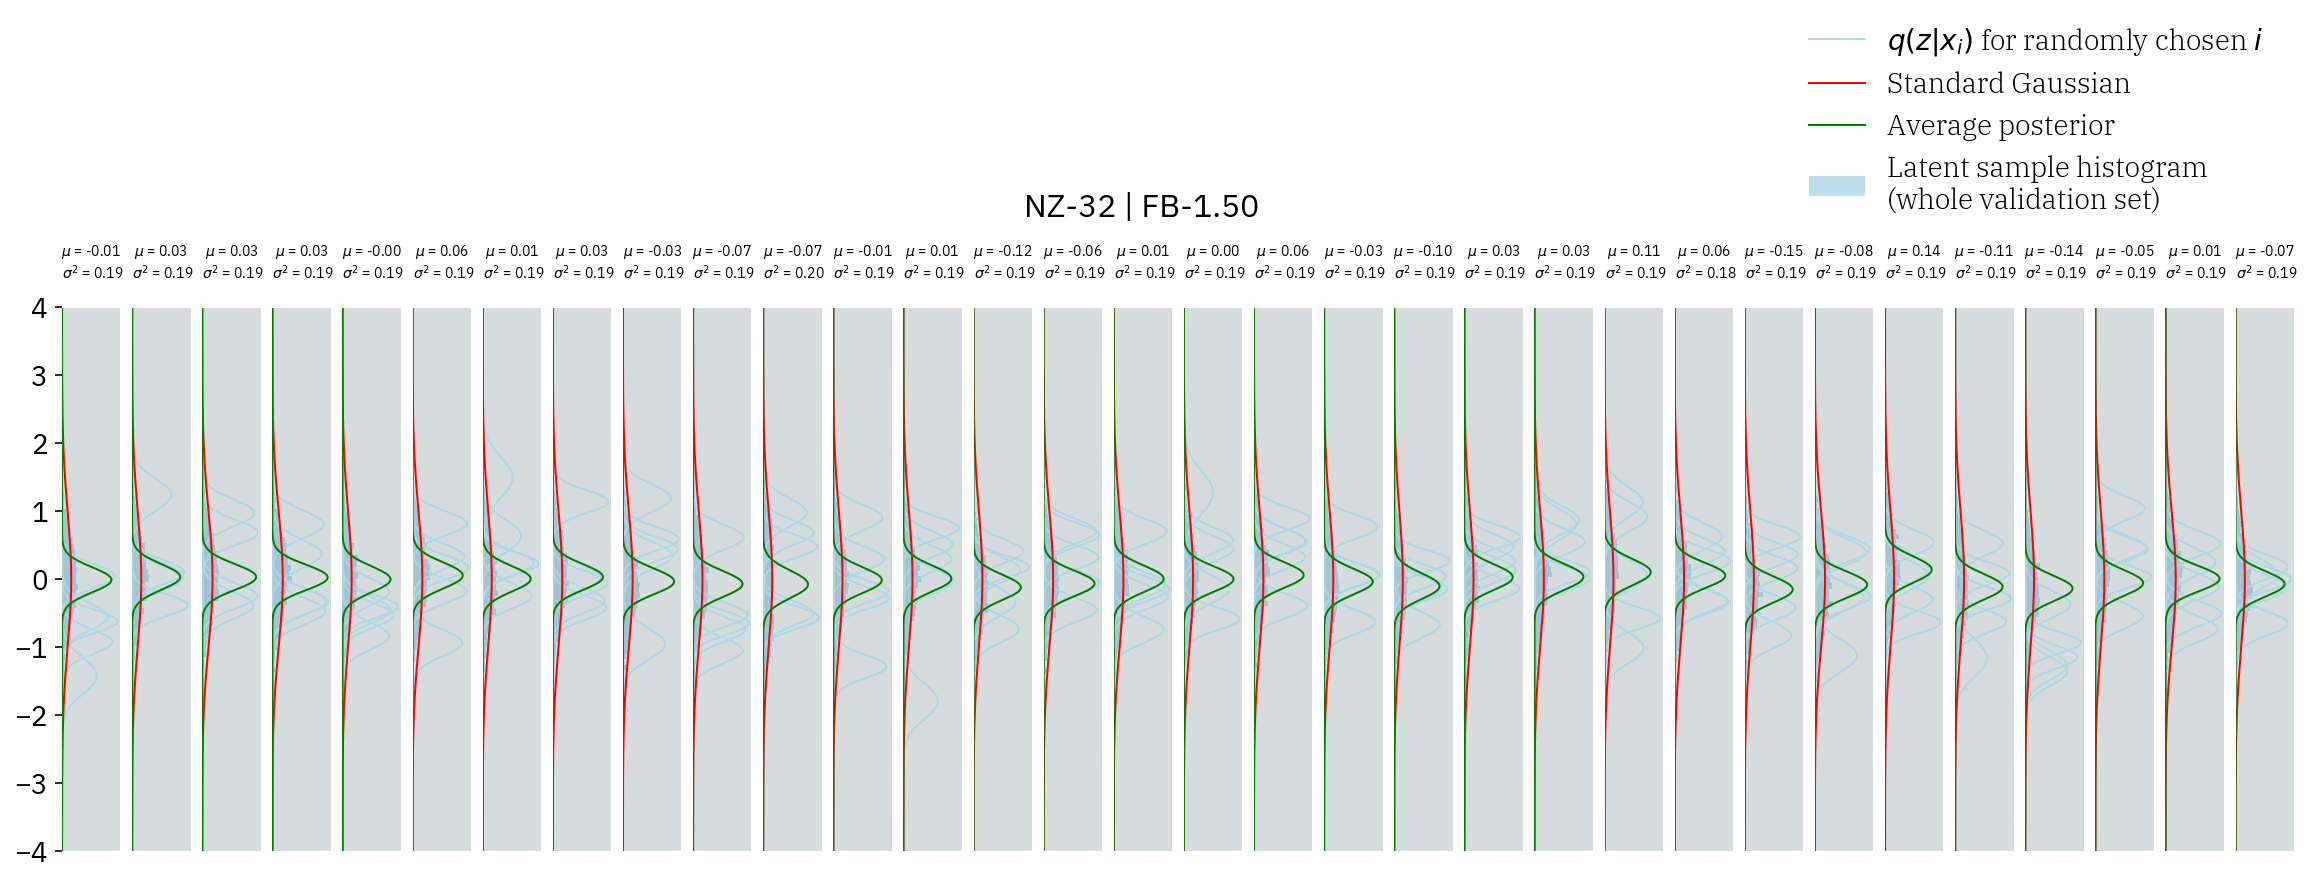

NZ-32 | autoencoder


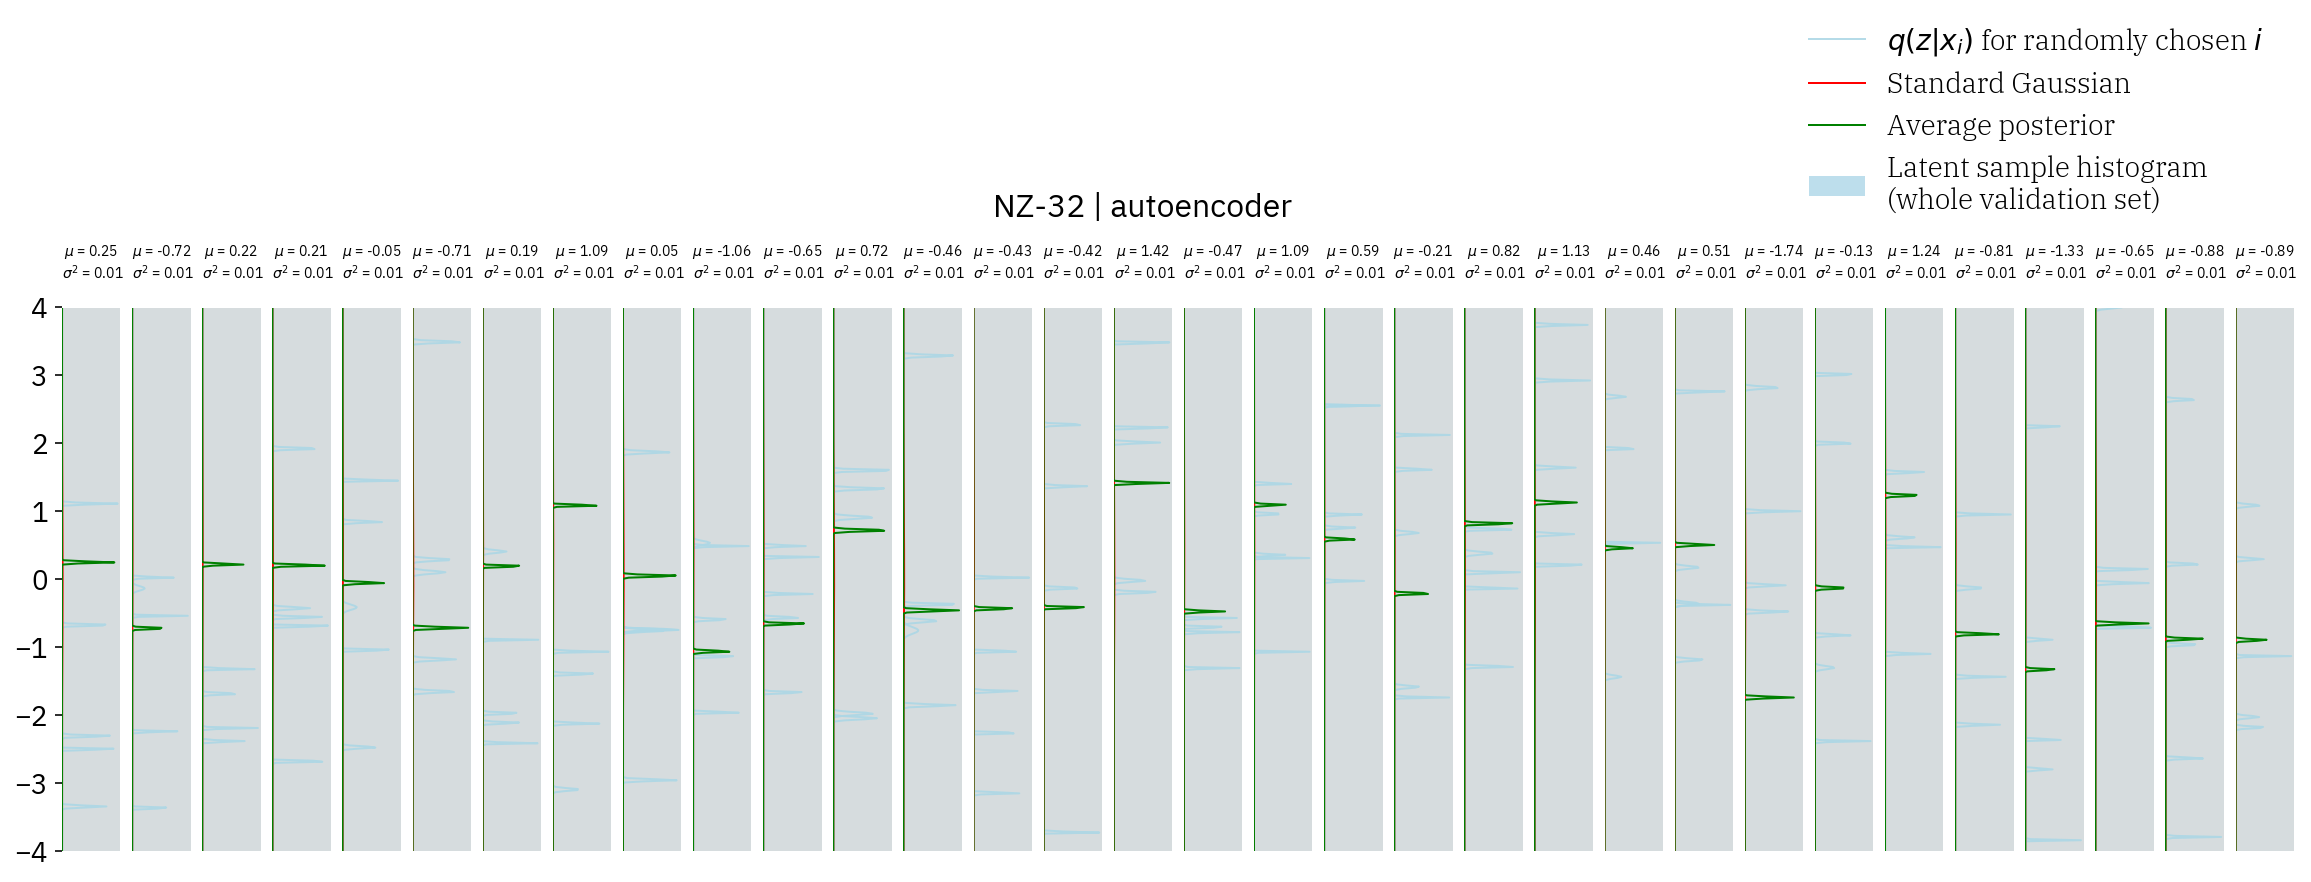

In [8]:
MODE = "TF"

import scipy.stats

x = np.linspace(-4, 4, 500)
y = scipy.stats.norm.pdf(x, 0, 1)

runs = \
["2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
 "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02", 
 "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17", 
 "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
 "2021-02-03-PTB-latent32-autoencoder-run-17:30:41"]

# for row, (r, r_dict) in enumerate(results_latents[MODE].items()):

for r in runs:
    r_dict = results_latents[MODE][r]
    latents = r_dict["latents"][:, :].numpy()
    
    mean = r_dict["mus"]
    mean_mean = mean.mean(dim=0)
    std = r_dict["logvars"].mul(0.5).exp()
    std_mean = std.mean(dim=0)
    
#     print(latents.shape)
    print(get_clean_name(r))
    
    latent_size = int(r.split("-")[4][-2:])
    
    fig, axs = plt.subplots(nrows=1, ncols=latent_size, figsize=(20, 5))

    
    N_separate_posteiors = 5
    
    for i in range(latent_size):
        # print("dim", i)
        axs[i].grid(b=False, which="both")
        
        y_mean_post_i = scipy.stats.norm.pdf(x, mean_mean[i], std_mean[i])
        
        if i > 0:
            axs[i].set_yticks([])
        axs[i].grid = False
        axs[i].set_xticks([])
        axs[i].hist(latents[:, i], orientation="horizontal", bins=50, density=True, alpha=0.3, label="Latent sample histogram\n(whole validation set)")
        axs[i].set_ylim([-4, 4])
        
        for n in range(N_separate_posteiors):
            
            choice_int = np.random.randint(0, len(latents))
            
            y_sep_post_i = scipy.stats.norm.pdf(x, mean[choice_int, i], std[choice_int, i])
            
            label = "$q(z|x_i)$ for randomly chosen $i$" if n == 0 else None
            
            axs[i].plot(y_sep_post_i, x, color='lightblue', linewidth=1, label=label, alpha=0.9)
        
        #axs[i].axhline(color='b', linewidth=1) #xmin=0, xmax=50, 
        axs[i].plot(y, x, color='r', linewidth=1, label="Standard Gaussian")
        axs[i].plot(y_mean_post_i, x, color='green', linewidth=1, label="Average posterior")
        axs[i].set_title(f"$\mu$ = {mean_mean[i]:.2f}\n $\sigma^2$ = {std_mean[i]:.2f}", size=7, y=1.03)
               
    axs[-1].legend(loc=(-7.5, 1.15), prop={'family':'serif','weight':300, 'size':14})

    fig.suptitle(get_clean_name(r), size=16, y=1.04)
    plt.show()
    #break

# Draw actual samples

In [23]:
n_samples = 100
device_name = "cuda:0"

runs = ["2021-02-03-PTB-latent32-autoencoder-run-17:30:41"]
# ["2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
#  "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02", 
#  "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17", 
#  "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
#  "2021-02-03-PTB-latent32-autoencoder-run-17:30:41"]

text_preds = {}
atts_to_latent = {}

for r in runs:
    
    p = PTB_run_name_paths[r]
    print(get_clean_name(r))
    
    latent_size = int(r.split("-")[4][-2:])
    
    vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                    latent_size=latent_size, 
                                    add_latent_via_memory=True,
                                    add_latent_via_embeddings=False, 
                                    do_tie_weights=True, 
                                    do_tie_embedding_spaces=True,
                                    add_decoder_output_embedding_bias=False)
    
    vae_model.eval()

    with torch.no_grad():
#         prior_sample = vae_model.sample_from_prior(latent_size, n_samples=n_samples, device_name=device_name)
        
        loc = torch.zeros(latent_size, device=device_name)
        scale = torch.ones(latent_size, device=device_name)*2.0
        prior_dist = torch.distributions.normal.Normal(loc, scale)
        prior_sample = prior_dist.sample((n_samples,))
        
        prior_sample = torch.zeros(latent_size, device=device_name)
        
        prior_decoded_ar = vae_model.decoder.autoregressive_decode(
                                                    prior_sample,
                                                    labels=None,
                                                    max_seq_len=32,
                                                    return_exact_match=False,
                                                    return_cross_entropy=False,
                                                    return_attention_probs=False,
                                                    return_attention_to_latent=True,
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_output_word_embeddings=False,
                                                    return_logits=False,
                                                    tokenizer=tokenizer,
                                                    nucleus_sampling=False, # <-- to check variability from the latent turn this off
                                                    reduce_seq_dim_ce="sum",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="mean",
                                                    device_name=device_name)
        
        atts_to_latent[r] = prior_decoded_ar["attention_to_latent"].cpu()

        prior_decoded_ar_text = tokenizer_batch_decode(prior_decoded_ar["predictions"], tokenizer)
        ts = []
        for t in prior_decoded_ar_text:
            index_end = t.find("</s>")
            if index_end == -1:
                ts.append(t)
            else:
                ts.append(t[:index_end])
        text_preds[r] = ts

NZ-32 | autoencoder
Loading model...
Replacing linear output layer with one without bias!


Some weights of the model checkpoint at roberta-base were not used when initializing VAE_Encoder_RobertaModel: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing VAE_Encoder_RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VAE_Encoder_RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VAE_Encoder_RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tying encoder decoder RoBERTa checkpoint weights!
<class 'modules.decoder_roberta_new.VaeDecoderRobertaModel'> and <class 'modules.encoder_roberta.VAE_Encoder_RobertaModel'> are not equal. In this case make sure that all encoder weights are correctly initialized. 
The following encoder weights were not tied to the decoder ['roberta/pooler']
Tying embedding spaces!
Done model...
Loading VAE_model, optimizer and scheduler from ../Runs/2021-02-03-PTB-latent32-autoencoder-run-17:30:41/checkpoint-best.pth
Removing module string from state dict from checkpoint
Checkpoint global_step: best, epoch: 56, best_valid_loss: 62.82812358714916


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

# Investigate autoencoder sampling

In [24]:

device_name = "cuda:0"

r = "2021-02-03-PTB-latent32-autoencoder-run-17:30:41"
p = PTB_run_name_paths[r]
vae_model = load_model_for_eval(p, device_name=device_name, 
                                latent_size=latent_size, 
                                add_latent_via_memory=True,
                                add_latent_via_embeddings=False, 
                                do_tie_weights=True, 
                                do_tie_embedding_spaces=True,
                                add_decoder_output_embedding_bias=False)

Loading model...
Replacing linear output layer with one without bias!


Some weights of the model checkpoint at roberta-base were not used when initializing VAE_Encoder_RobertaModel: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing VAE_Encoder_RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VAE_Encoder_RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of VAE_Encoder_RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tying encoder decoder RoBERTa checkpoint weights!
<class 'modules.decoder_roberta_new.VaeDecoderRobertaModel'> and <class 'modules.encoder_roberta.VAE_Encoder_RobertaModel'> are not equal. In this case make sure that all encoder weights are correctly initialized. 
The following encoder weights were not tied to the decoder ['roberta/pooler']
Tying embedding spaces!
Done model...
Loading VAE_model, optimizer and scheduler from ../Runs/2021-02-03-PTB-latent32-autoencoder-run-17:30:41/checkpoint-best.pth
Removing module string from state dict from checkpoint
Checkpoint global_step: best, epoch: 56, best_valid_loss: 62.82812358714916


In [27]:
vae_model.eval()
n_samples = 10

results = {}

with torch.no_grad():
    
    priors_dif_scales = {}
    
    for scale in [0.0, 1.0, 2.0, 4.0, 8.0]:
        loc = torch.zeros(latent_size, device=device_name)
        std = torch.ones(latent_size, device=device_name) * scale
        prior_dist = torch.distributions.normal.Normal(loc, std)
        prior_sample = prior_dist.sample((n_samples,))
        priors_dif_scales[scale] = prior_sample

    for scale, prior_sample in priors_dif_scales.items():
        prior_decoded_ar = vae_model.decoder.autoregressive_decode(
                                                    prior_sample,
                                                    labels=None,
                                                    max_seq_len=32,
                                                    return_exact_match=False,
                                                    return_cross_entropy=False,
                                                    return_attention_probs=False,
                                                    return_attention_to_latent=True,
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_output_word_embeddings=False,
                                                    return_logits=False,
                                                    tokenizer=tokenizer,
                                                    nucleus_sampling=False, # <-- to check variability from the latent turn this off
                                                    reduce_seq_dim_ce="sum",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="mean",
                                                    device_name=device_name)

        prior_decoded_ar_text = tokenizer_batch_decode(prior_decoded_ar["predictions"], tokenizer)
        
        ts = []
        for t in prior_decoded_ar_text:
            index_end = t.find("</s>")
            if index_end == -1:
                ts.append(t)
            else:
                ts.append(t[:index_end])
        
        results[scale] = {
            "attention_to_latent": prior_decoded_ar["attention_to_latent"].cpu(),
            "text": ts
        }

Scale:0.0



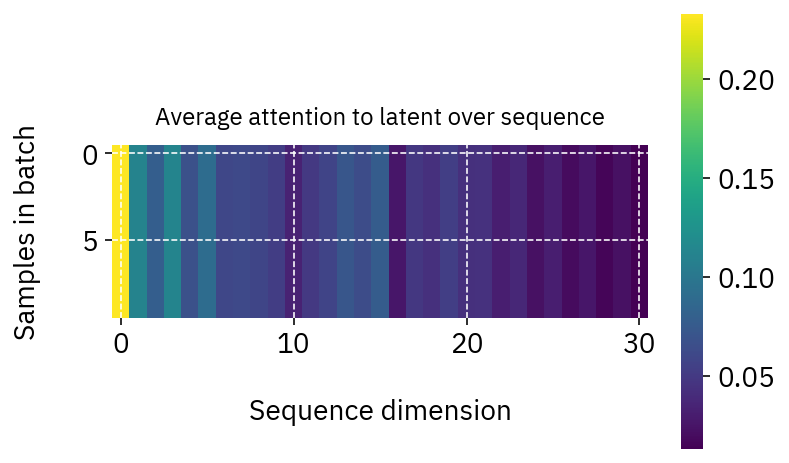

0 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
1 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
2 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
3 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
4 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
5 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
6 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
7 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
8 shearson is among the first to publish detailed environmental scenarios without <unk> the hugo scenarios
9 shearson is among the first to publ

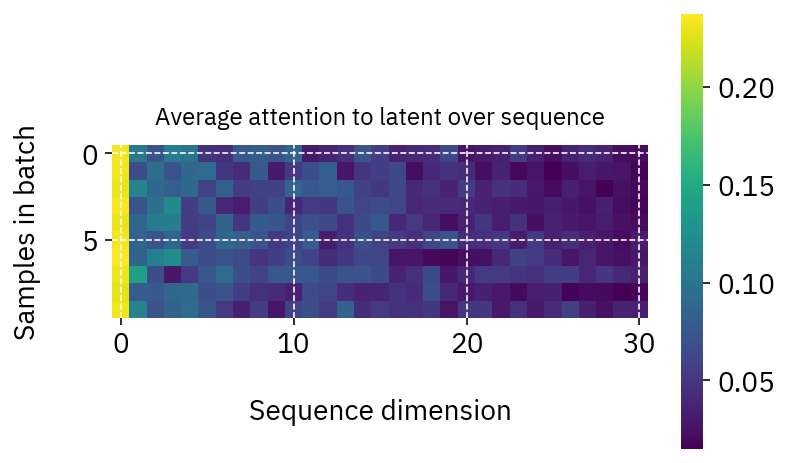

0 shearson is the lone surviving <unk> of the junk bond swap and another riskier than the junk bond swap
1 friday delivery was a critical stop for earthquake victims and the mail room
2 my N would be among the last to pack the <unk> and many others for fear of falling
3 nor is the apple a mere staging site for war movies
4 meanwhile a national laboratory is awaiting <unk> reports on its condition and the cost of new diagnostic tests
5 thomas a. <unk> was also named to the advisory panel and noted further developments in the market's volatility
6 meanwhile the new contract covers only petroleum and <unk> metals according to a ministry of international trade and industry official
7 the soviet union has already dispatched two <unk> of <unk> for vermont and vermont says one of them
8 seagram expects to publish N more so-called <unk> columns each month
9 i look at a few emerging savings and loan portfolios and realized the problem wasn't my fault
------------------------------
-------------

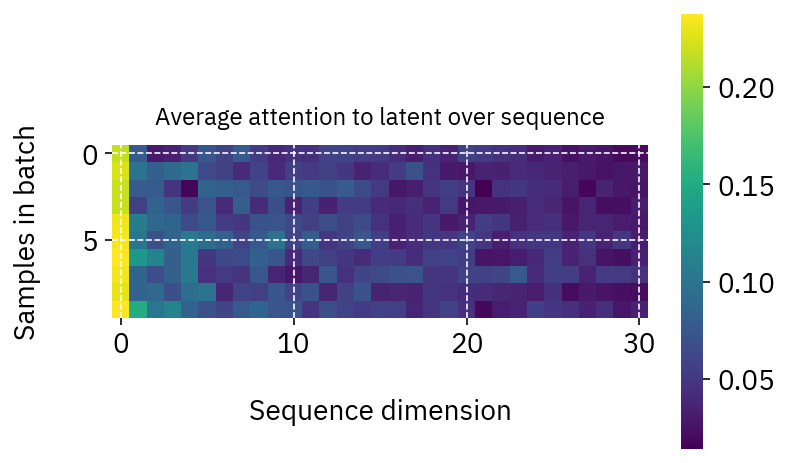

0 moody's dropped the sagging indicator from the <unk> and then fails to detect the <unk>
1 he proposed that the new N crop be introduced in N by N next year
2 mr. dinkins also has been <unk> for <unk> to hong kong and tokyo and perhaps to new york or new y
3 indeed to avoid this trap a basket of futures and options could be placed together to form a cross-border basket
4 now she has presented her lawyer david <unk> who hopes to develop a new medical foundation for human rights
5 honda <unk> were also affected by the availability of dealerships that offer safety features such as <unk> shocks and <unk> shocks
6 it was once the nation's <unk> brokerage firm attracting investors eager to buy stocks that <unk> european markets
7 meeting with the financial secretary of the house of commons mr. <unk> had written and <unk> about the implication of this article
8 mr. green has a perfectly good garden that requires a permit
9 the <unk> came so quickly as many people were scrambling to find out 

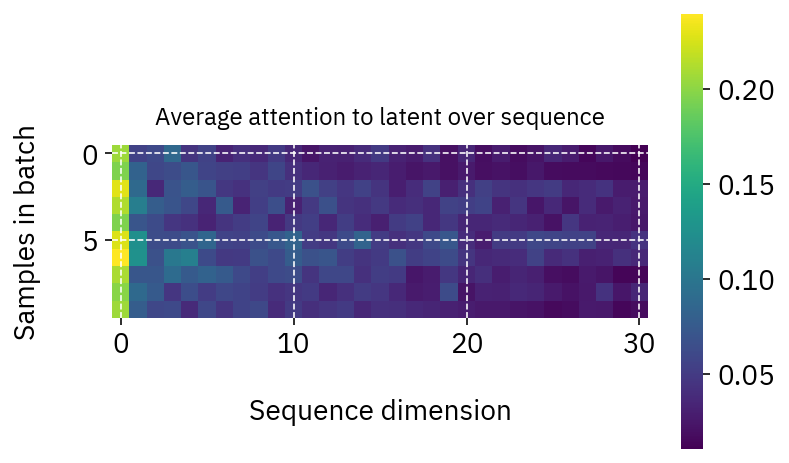

0 unfortunately the process is difficult to undo and is difficult to undo by a worm in the dark is only a few steps
1 still might suggest that might might also challenge that
2 michigan N N average rate of N N was N N on N million shares a week earlier
3 <unk> pencil pencil sellis harvard so harvard says digital digital so easy and so <unk>
4 Before he had been considered to be a candidate for a proposal to be proposed by a group of her brother who had been rejected
5 the continuing battle over the same region continues at the same level as the recent sharp reversal of the reagan administration's <unk>
6 the union said the u.s. government willn't meet formally today but officials expect to meet later thursday
7 se's <unk> has remained unchanged and its daily <unk> delivery has a brief closing
8 some also occasionally are seeking to have another person for some additional investment in some other or other iversally staying for some other long term
9 something something is going to happe

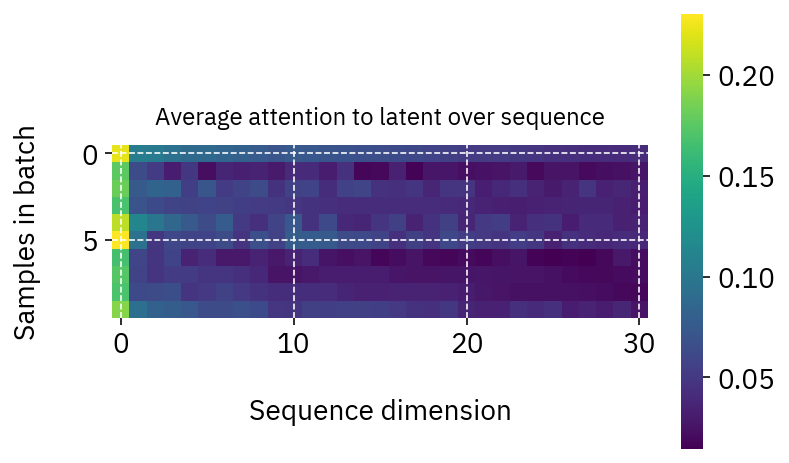

0 hiss has has't't't'thehehehehehehehehehehehehehehehehehehehehehehe
1 we weft wefti must we state that we state the criminal statute is criminal and we we state it is criminal and we we state it is criminal
2  Marks are the forces the forces were the forces and the movements were the forces of the forces and the movements of the forces of the Master and the forces
3  clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear clear
4 but and and all of the and most of the book and its articles and the articles and the articles and the articles and the articles which have and have certainly
5 b teleli telecommunications corp ljark corp said said said closed closed bell telel corp
6 they think the ones are higher in the range that the ones that are higher and the ones that are higher and the ones that are higher above the way they
7 hehehehetextex supplies supplies rei

In [28]:
for s, r in results.items():
    print(f"Scale:{s}")
    print()
    
    aw = r["attention_to_latent"]
    
    aw_mean_head_layers = aw.mean(dim=1).mean(dim=1)
    plt.imshow(aw_mean_head_layers.numpy())
    
    plt.title("Average attention to latent over sequence", y=1.05, size=12)
    plt.colorbar()
    plt.ylabel("Samples in batch")
    plt.xlabel("Sequence dimension")
    plt.show()
    
    ts = r["text"]
    
    for i, t in enumerate(ts):
        print(i, t)
    print("-"*30)
    print("-"*30)

****************************************
NZ-32 | autoencoder
****************************************


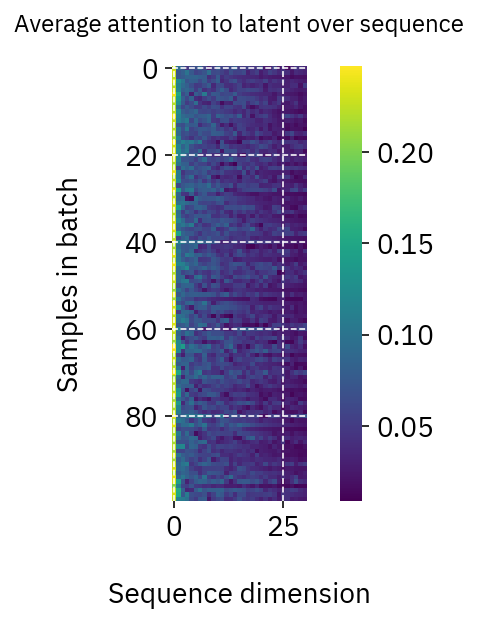

0 michael f. <unk> new york is currently preparing for the additional responsibilities of president of the regional bank and director of credit services
1 house rules are just set up so the two can work together and then have a working relationship with law enforcement
2 already there is a <unk> buried under the town
3 but one day he is going to fly to the red cross for a few hundred dollars
4 there are a few tricky swings in the price of a particular product or a shift in demand or a lack of one to come along said a dealer
5 he might also have disappointed his east german counterparts but those won't be <unk>
6 the prof. boren feared the damage to his city
7 the people of the east berlin to demand <unk> of the banned <unk> began to publish articles of national emergency
8 the current talks between the u.s. and european <unk> are subject to a reduction of import barriers and exchange rate changes
9 sales will remain broadly same with no <unk> or <unk> barometer the best-known <unk>
10 

In [22]:
for (r, ts), (_, aw) in zip(text_preds.items(), atts_to_latent.items()):
    print("*"*40)
    print(get_clean_name(r))
    print("*"*40)
    # batch, n_heads, n_layers, seq_len_query, seq_len_val
    # attention_to_latent = attention_probs[:, :, :, :-1, 0]
    aw_mean_head_layers = aw.mean(dim=1).mean(dim=1)
#     print(aw_mean_head_layers.shape)
#     print(aw.shape)
    plt.imshow(aw_mean_head_layers.numpy())
    
    plt.title("Average attention to latent over sequence", y=1.05, size=12)
    plt.colorbar()
    plt.ylabel("Samples in batch")
    plt.xlabel("Sequence dimension")
    plt.show()
    for i, t in enumerate(ts):
        print(i, t)
        
    print("-"*30)

# 2 Active units (same for TF as for AR, only about encoding)

In [6]:
results_active_units = {}

RESULT_FILE = RESULT_DIR / f"result_active_units.pickle"

if os.path.exists(RESULT_FILE):
    print(f"Loading file {RESULT_FILE}, it existed.")
    res_dict = pickle.load( open( RESULT_FILE, "rb" ) )
else:
    res_dict = {}

for i, (r, p) in enumerate(PTB_run_name_paths.items()):
    print(i, r)

    if r in res_dict:
        print("Skipping this run, already in result dict!")
        continue

    latent_size = int(r.split("-")[4][-2:])
    vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                    latent_size=latent_size, 
                                    add_latent_via_memory=True,
                                    add_latent_via_embeddings=False, 
                                    do_tie_weights=True, 
                                    do_tie_embedding_spaces=True,
                                    add_decoder_output_embedding_bias=False)


    N = len(validation_loader)
    means = []
    with torch.no_grad():
        for batch_i, batch in enumerate(validation_loader):
            print(f"{batch_i:3d}/{N}", end="\r")
            batch = transfer_batch_to_device(batch, DEVICE)

            n_samples = 1
            enc_out = vae_model.encoder.encode(batch["input_ids"], batch["attention_mask"], n_samples=n_samples,
                                              hinge_kl_loss_lambda=0.0,
                                              return_log_q_z_x=True,
                                              return_log_p_z=True,
                                              return_embeddings=False)
            means.append(enc_out["mu"])

        means = torch.cat(means, dim=0)

        outer_expectation = torch.mean(means, dim=0)**2
        inner_expectation = torch.mean(means**2, dim=0)
        delta = 0.01

        AU = torch.sum(inner_expectation - outer_expectation > delta).item()
        var = inner_expectation - outer_expectation
        print(var.shape)

        plt.title(f"{r} | Active units: {AU}")
        plt.bar(np.arange(len(var)), var.cpu().numpy())
        plt.show()

        res_dict[r] = {
            "active_units": AU,
            "variance": var.cpu().numpy()
        }

        print(f"{get_clean_name(r)}, number of AU: {AU}")

        # Dump results after every model so we don't need to start over in case of a crash
        pickle.dump( res_dict, open( RESULT_FILE, "wb" ) )

results_active_units = res_dict

Loading file result-files/result_active_units.pickle, it existed.
0 2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Skipping this run, already in result dict!
1 2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Skipping this run, already in result dict!
2 2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Skipping this run, already in result dict!
3 2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Skipping this run, already in result dict!
4 2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Skipping this run, already in result dict!
5 2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Skipping this run, already in result dict!
6 2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Skipping this run, already in result dict!
7 2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Skipping this run, already in result dict!
8 2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
Skipping this run, already in result dict!
9 2021-02-03-PTB-latent64-autoencoder-run-18:25:57
Skipping this run, already in result dict!
10 2021-02-02-PTB-latent32-FB

In [18]:
MODE = "TF"

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(14, 18), dpi=300)

order = ["FB-0.0", "FB-0.25", "FB-0.5", "FB-0.75", "FB-1.0", "FB-1.5", "autoencoder"]


for r, d in results_active_units[MODE].items():
    for o in order:
        if o in r:
            row = order.index(o)
    latent_size = int(r.split("-")[4][-2:])
    if latent_size == 32:
        col = 0
    else:
        col = 1
    
    axs[row, col].set_title(get_clean_name(r), size=10)
    # for different colours
    # cs = [(77/256, 165/256, 183/256, v/np.max(d["variance"])) for v in list(d["variance"])]
    axs[row, col].bar(np.arange(latent_size), d["variance"]) #, color=cs
    axs[row, col].set_ylim([0, 0.6])
    axs[row, col].axhline(y=0.1, color='#f28c6d', linewidth=2.0, label='Threshold $\epsilon$ for A.U.')
    if row == 6:
        axs[row, col].set_xlabel("Dimension of z")
    if col == 0:
        axs[row, col].set_ylabel("Variance")
    if row == 0 and col == 1:
        axs[row, col].legend(loc=(0.58, 1.15), prop={'family':'serif','weight':300, 'size':14})

fig.suptitle("Variance of the posterior means of encoding the validation set.", size=20, y=1.0)
fig.tight_layout()
plt.savefig(RESULT_DIR / f"variance_active_units_{MODE}.png", dpi=300)
plt.show()

# KL-per dimension

W0224 22:03:01.588848 22738332843776 legend.py:1193] No handles with labels found to put in legend.
/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


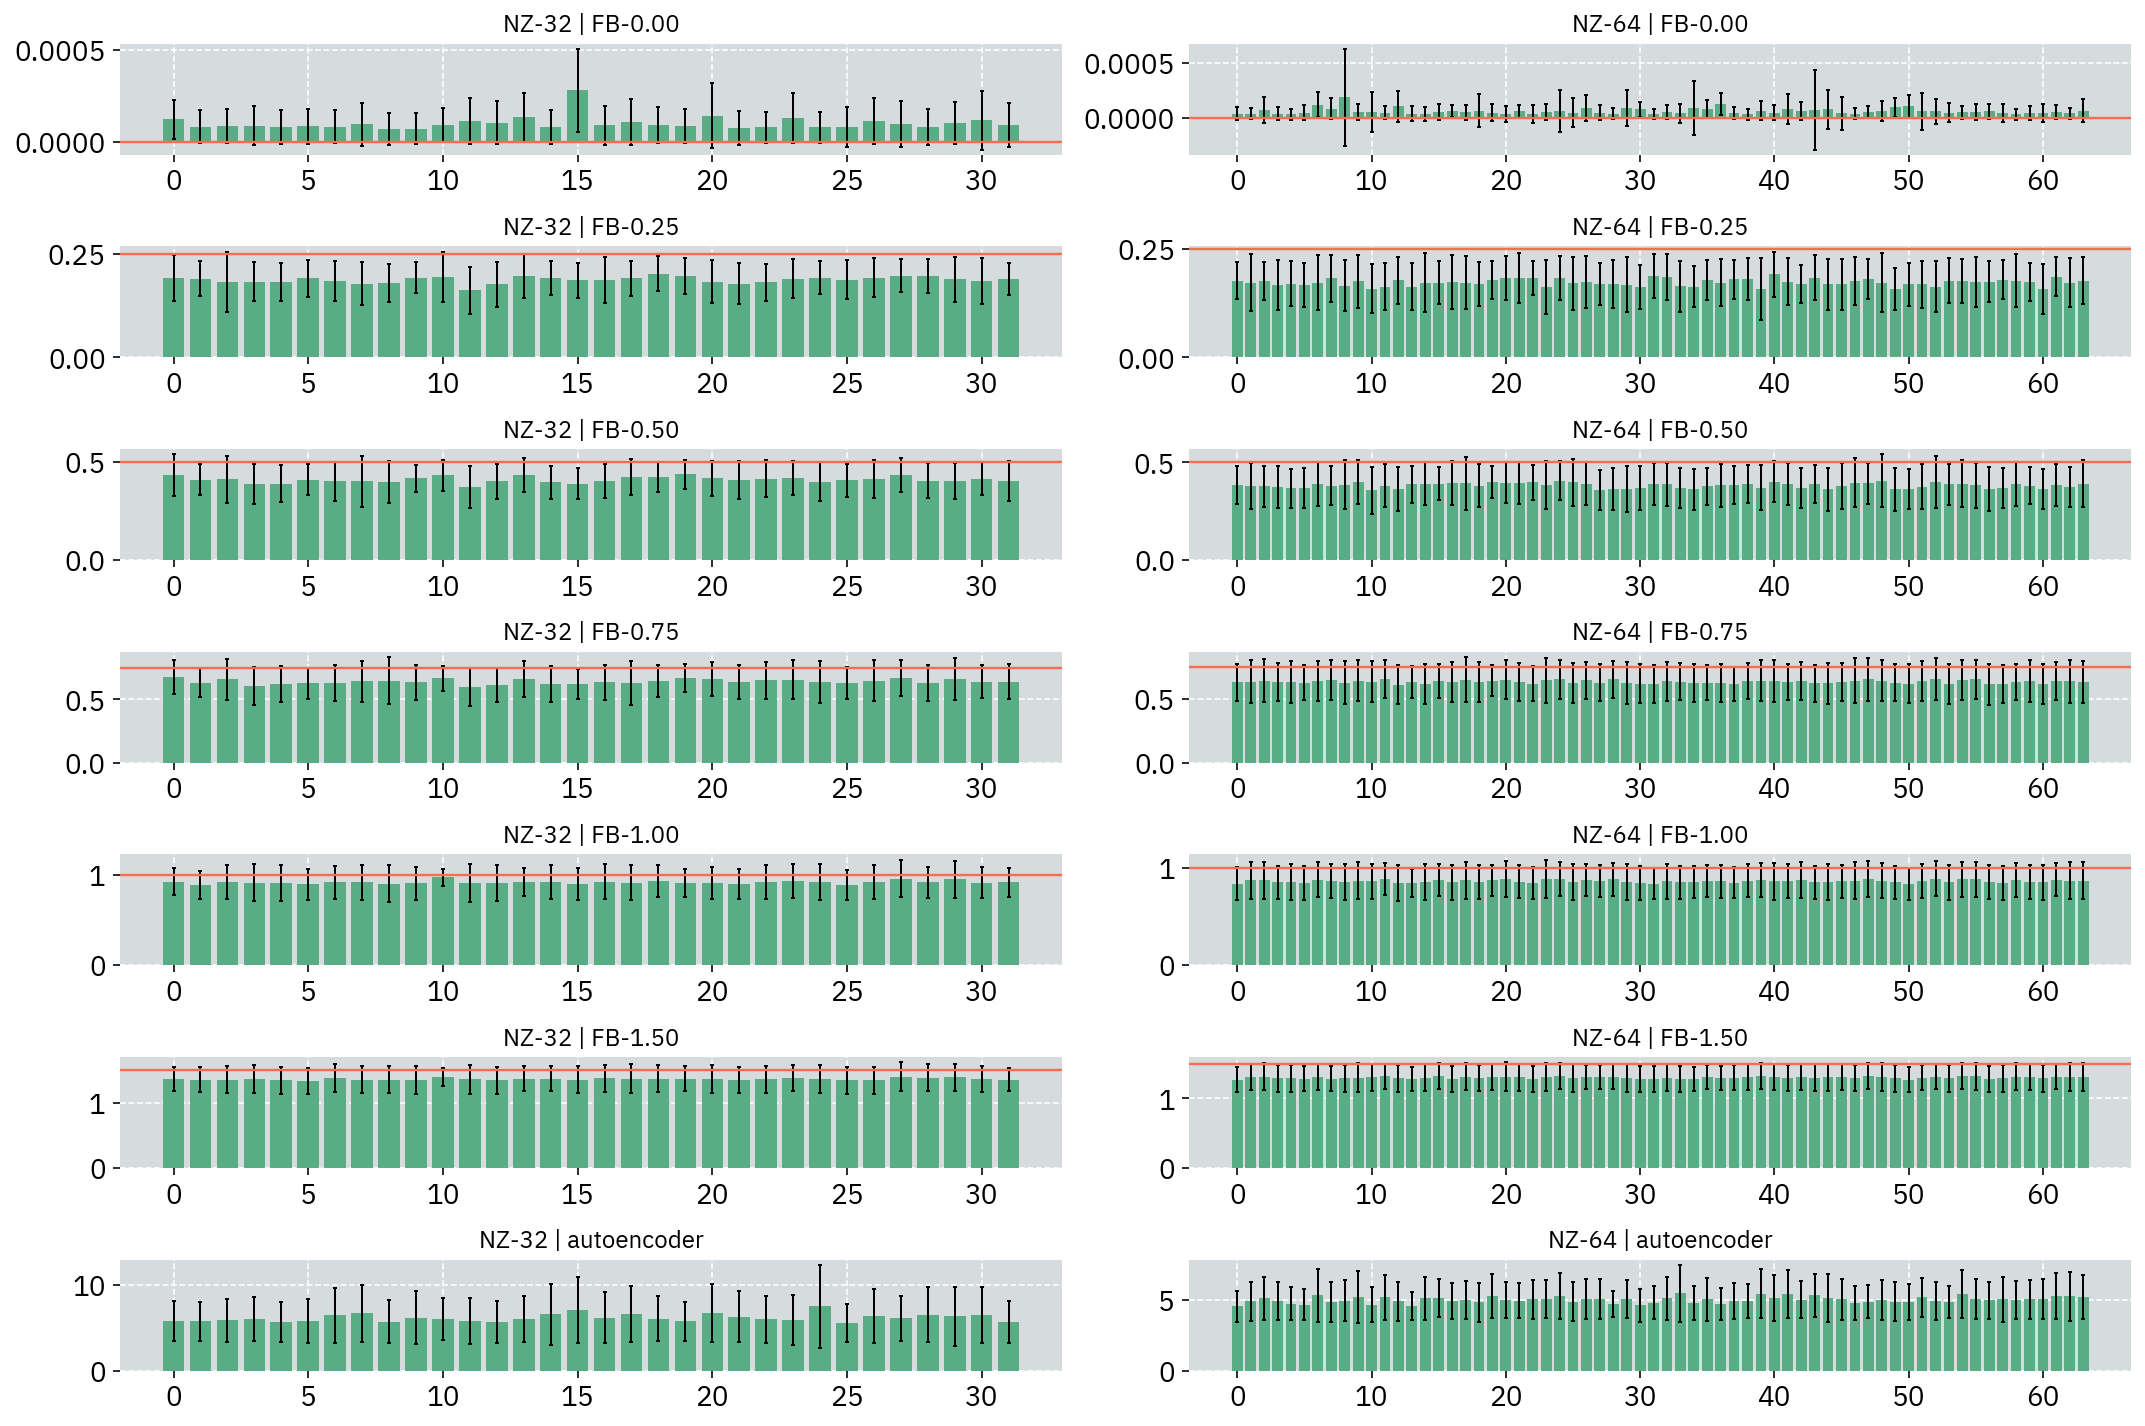

In [7]:
order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]


fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15, 10))

for o in order:
    
    row = order.index(o) % 7
    
    if "autoencoder" in o:
        FB = -1
    else:
        FB = float(o.split("-")[6])

# for run_name, d in results_latents["TF"].items():

    d = results_latents["TF"][o]
    
    if "latent32" in o:
        col = 0
    else:
        col = 1
    
#     print(run_name)
    #print(d.keys())
    
    mu, logvar = d["mus"], d["logvars"]
    kl_loss = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1)
    
    kl_mean = kl_loss.mean(dim=0)
    kl_std = kl_loss.std(dim=0)
    
    error_kw=dict(lw=1, capsize=1, capthick=1)
    
    axs[row, col].bar(np.arange(len(kl_mean)), kl_mean.numpy(), yerr=kl_std.numpy(), error_kw=error_kw, color="#58AD85")
    axs[row, col].set_title(get_clean_name(o), fontsize=12)
    
    if FB != -1:
        axs[row, col].axhline(FB, linewidth=1.2, color="#F46E4F")
    
plt.legend()
plt.tight_layout()
plt.savefig(RESULT_DIR / "KL_div_per_dimension.png", bbox="tight_inches", dpi=300)

# Aggregated posterior

torch.Size([32])
2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
2.4825334548950195e-05
torch.Size([32])
2021-02-02-PTB-latent32-FB-0.25-run-13:16:32
0.09086491912603378
torch.Size([32])
2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
0.26756751537323
torch.Size([32])
2021-02-02-PTB-latent32-FB-0.75-run-12:44:32
0.48151695728302
torch.Size([32])
2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
0.7367812991142273
torch.Size([32])
2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
1.1895220279693604
torch.Size([32])
2021-02-03-PTB-latent32-autoencoder-run-17:30:41
4.346782684326172
torch.Size([64])
2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
2.1292828023433685e-05
torch.Size([64])
2021-02-02-PTB-latent64-FB-0.25-run-13:17:02
0.09327366203069687
torch.Size([64])
2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
0.2691158056259155
torch.Size([64])
2021-02-02-PTB-latent64-FB-0.75-run-13:16:36
0.49739766120910645
torch.Size([64])
2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
0.7199584245681763
torch.Size([64])
2021

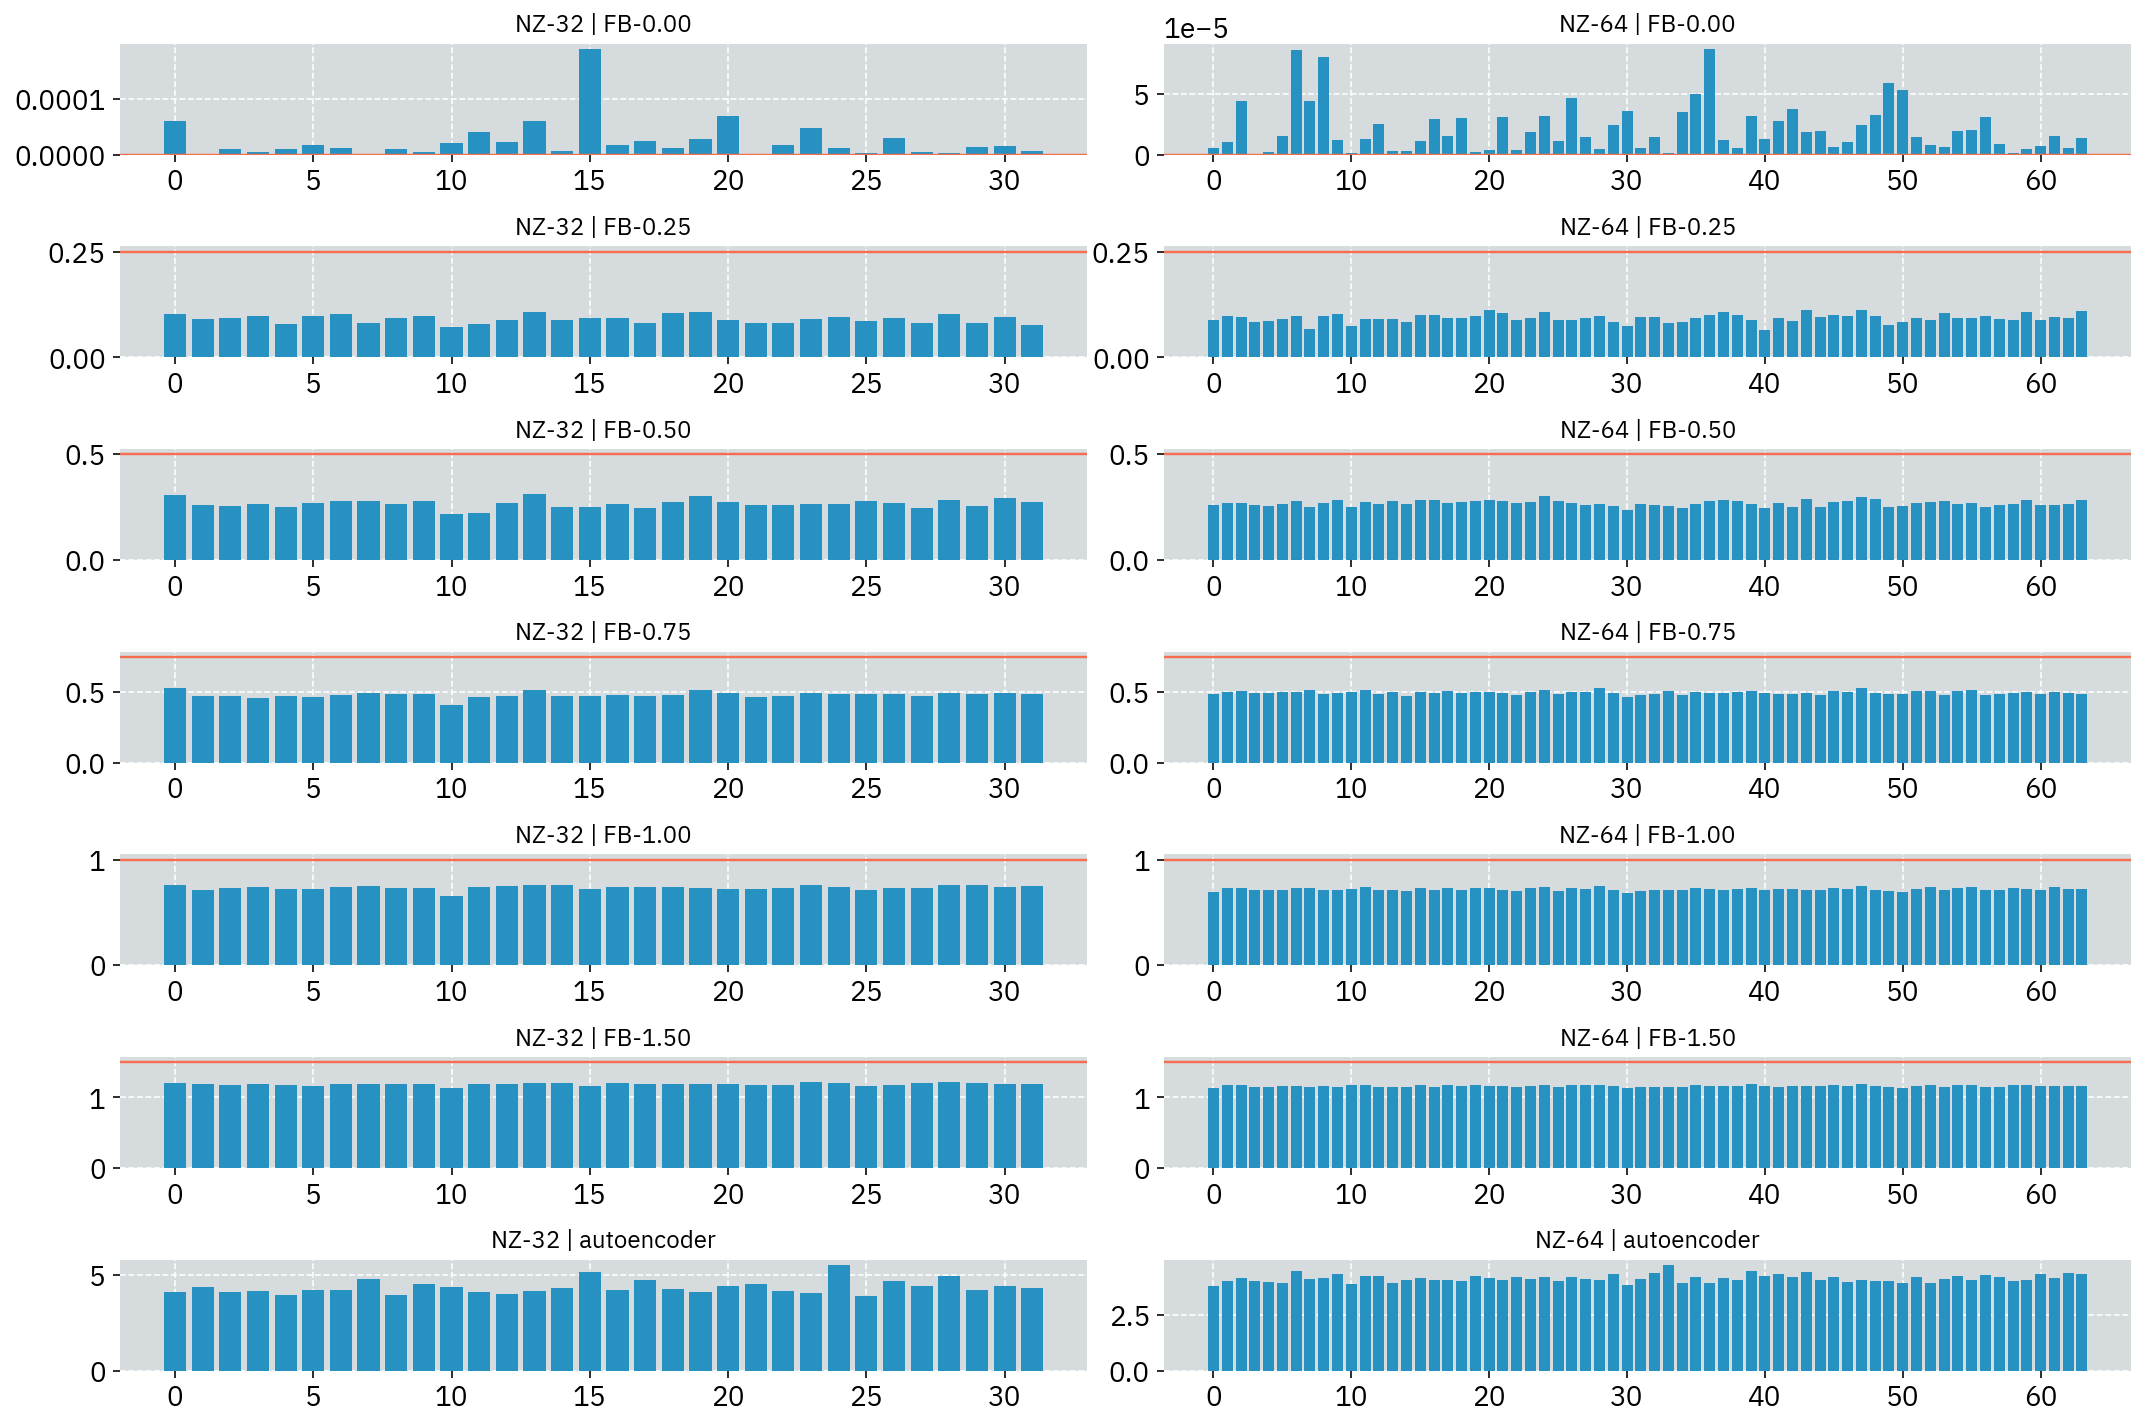

In [45]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15, 10))

for o in order:
    
    row = order.index(o) % 7
    
     
    if "autoencoder" in o:
        FB = -1
    else:
        FB = float(o.split("-")[6])
    
    d = results_latents["TF"][o]
    
    if "latent32" in o:
        col = 0
    else:
        col = 1
    
    mu, logvar = d["mus"], d["logvars"]
    
    mean_mu, mean_logvar = mu.mean(dim=0), logvar.mean(dim=0)
    
    kl_loss = 0.5 * (mean_mu.pow(2) + mean_logvar.exp() - mean_logvar - 1)
    
    print(kl_loss.shape)
    
    print(o)
    print(kl_loss.mean().item())
    
    axs[row, col].bar(np.arange(len(kl_loss)), kl_loss.numpy())
    axs[row, col].set_title(get_clean_name(o), fontsize=12)
    
    if FB != -1:
        axs[row, col].axhline(FB, linewidth=1.2, color="#F46E4F")
    
plt.tight_layout()
plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


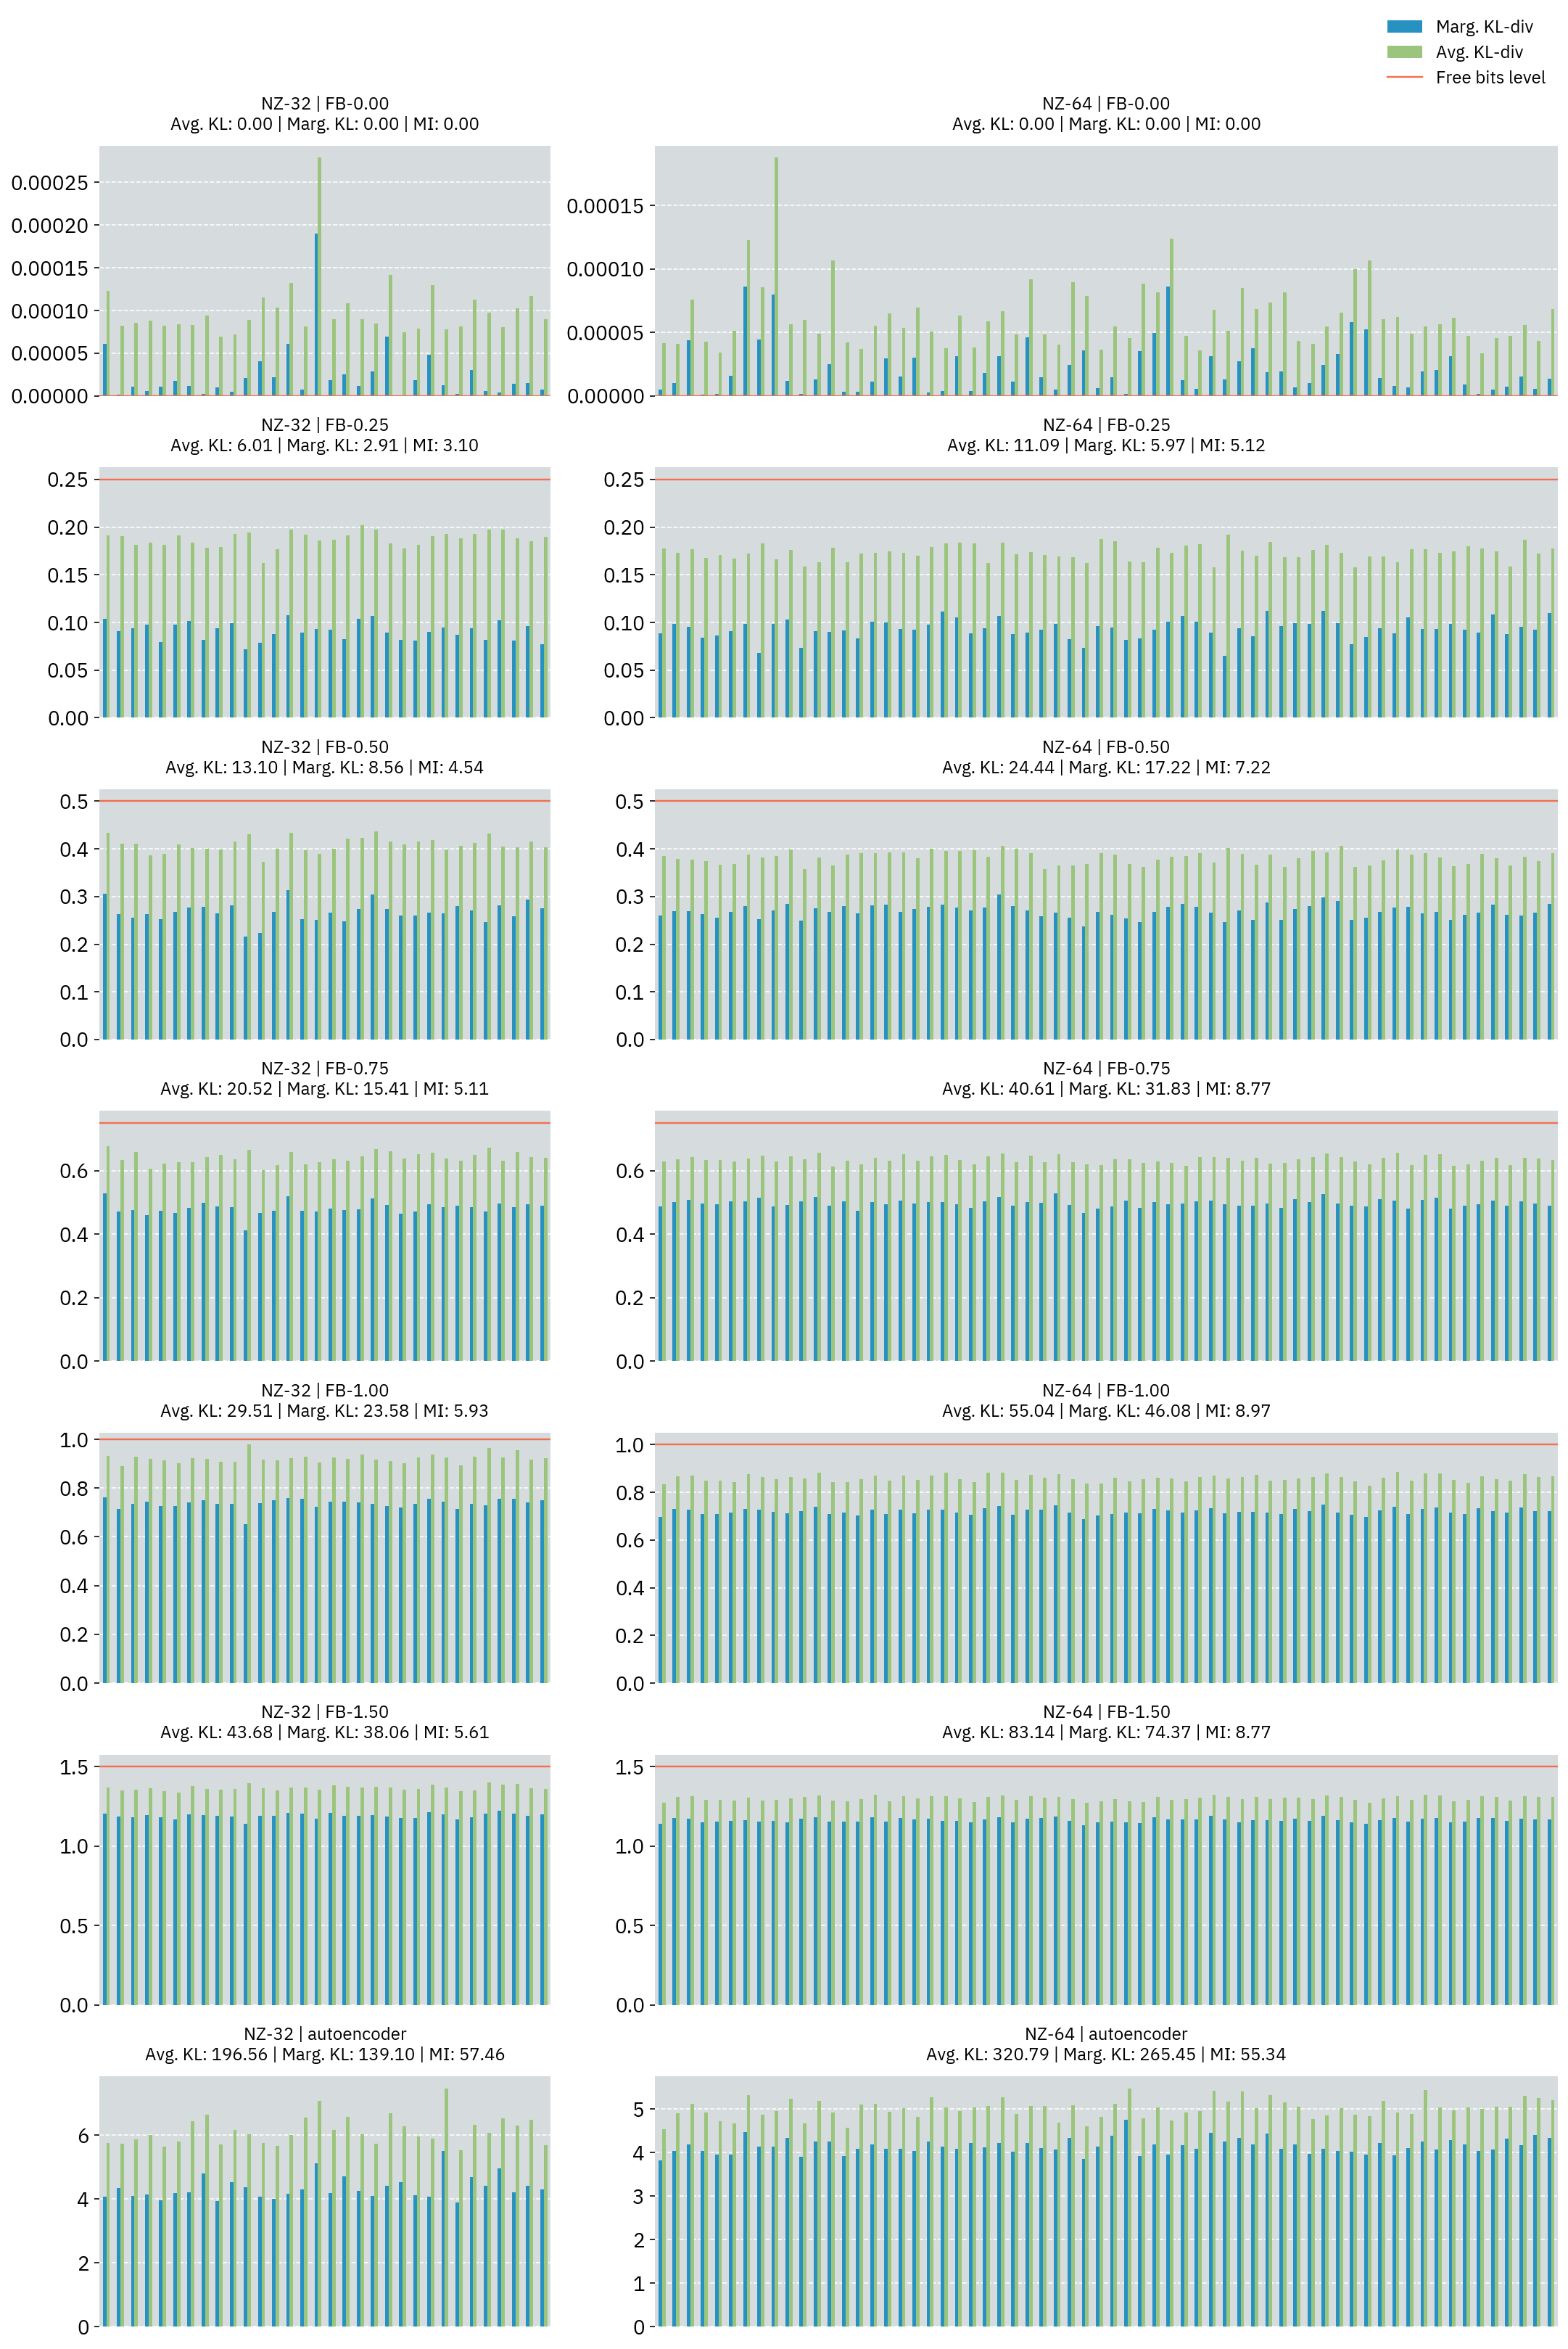

In [18]:
order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]

import matplotlib

matplotlib.rcParams["figure.figsize"] = (10, 3)


fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(15, 22), gridspec_kw={"width_ratios":[1, 2]})

kl_results = {}

for o in order:
    
    row = (order.index(o) % 7) #* 2
    
    if "autoencoder" in o:
        FB = -1
    else:
        FB = float(o.split("-")[6])

    d = results_latents["TF"][o]
    
    if "latent32" in o:
        col = 0
    else:
        col = 1
    
    mu, logvar = d["mus"], d["logvars"]
    kl_loss = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1)
    
    kl_mean = kl_loss.mean(dim=0)
    kl_std = kl_loss.std(dim=0)
    
    mean_mu, mean_logvar = mu.mean(dim=0), logvar.mean(dim=0)
    aggregated_kl_loss = 0.5 * (mean_mu.pow(2) + mean_logvar.exp() - mean_logvar - 1)
        
    AVG_KL = np.sum(kl_mean.tolist())
    MARG_KL = np.sum(aggregated_kl_loss.tolist())
    MI = AVG_KL - MARG_KL
    
    group_data = {
        
        "Marg. KL-div": aggregated_kl_loss.tolist(),
        "Avg. KL-div": kl_mean.tolist(),
        "kl_std": kl_std.tolist(),
        
        "MI": MI,
        "AVG_KL": AVG_KL,
        "MI": MI
        
    }
    
    
    df = pd.DataFrame(group_data)
    

    df[["Marg. KL-div", "Avg. KL-div"]].plot.bar(ax=axs[row, col])
    
    axs[row, col].set_xticks([])
    
    
    title = get_clean_name(o) + "\n" + f"Avg. KL: {AVG_KL:.2f} | " + f"Marg. KL: {MARG_KL:.2f} | " + f"MI: {MI:.2f}"
    
    axs[row, col].set_title(title, fontsize=12, y=1.03)
    
    if FB != -1:
        l1 = axs[row, col].axhline(FB, linewidth=1.2, color="#F46E4F", label="Free-bits level")
    
    axs[row, col].get_legend().remove()

lines, labels = fig.axes[-2].get_legend_handles_labels()
lines.append(l1)
labels.append("Free bits level")
fig.legend(lines, labels, loc = (0.88, 0.96), prop={"size" : 12})
fig.suptitle(" ", y=1.02)
plt.tight_layout()
plt.savefig(RESULT_DIR / "KL_div_per_dimension_aggregated_and_avg.png", bbox="tight_inches", dpi=300)